In [22]:
import pandas as pd
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# read in all our data
item_data = pd.read_csv("Train.csv")

# set seed for reproducibility
np.random.seed(0) 
item_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [23]:
import fuzzywuzzy
from fuzzywuzzy import process
import charset_normalizer

In [24]:
def replace_matches_in_column(df, column, string_to_match, min_ratio = 47):
    # get a list of unique strings
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match

In [25]:
replace_matches_in_column(df=item_data, column='Item_Fat_Content', string_to_match="Low Fat")
replace_matches_in_column(df=item_data, column='Item_Fat_Content', string_to_match="Regular")
item_data['Item_Fat_Content'] = item_data['Item_Fat_Content'].replace('LF' ,'Low Fat')
fat_contents = item_data.Item_Fat_Content.unique()
fat_contents.sort()
fat_contents

array(['Low Fat', 'Regular'], dtype=object)

In [26]:
updated_df = item_data
updated_df['Item_Weight']=updated_df['Item_Weight'].fillna(updated_df['Item_Weight'].mean())
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [27]:
updated_df["Outlet_Establishment_Year"] = updated_df["Outlet_Establishment_Year"] .astype('object')
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   object 
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), object(8)
memory usage: 799.2+ KB


In [36]:
dupe = updated_df.duplicated()
print(dupe.sum())

0


<Axes: >

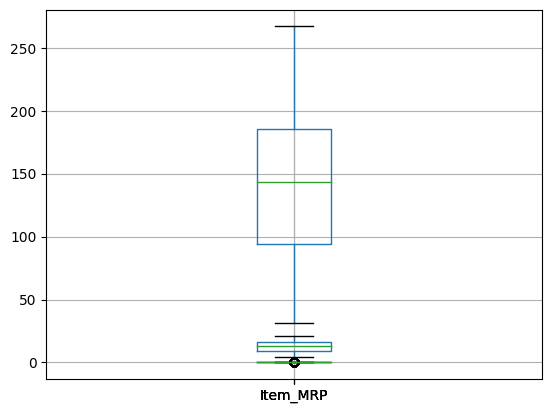

In [57]:
updated_df.boxplot(column="Item_Weight")
updated_df.boxplot(column="Item_Visibility")
updated_df.boxplot(column="Item_MRP")


In [59]:
q1 = updated_df["Item_Visibility"].quantile(0.25)
q2 = updated_df["Item_Visibility"].quantile(0.75)

IQR = q2 - q1

max_limit = q2 + (1.5 * IQR)
min_limit = q1 - (1.5 * IQR) 

q1_mrp = updated_df["Item_MRP"].quantile(0.25)
q2_mrp= updated_df["Item_MRP"].quantile(0.75)

IQR_mrp = q2_mrp - q1_mrp

max_limit_mrp = q2_mrp + (1.5 * IQR_mrp)
min_limit_mrp = q1_mrp - (1.5 * IQR_mrp) 


# norm_upper_limit = updated_df["Item_Visibility"].mean() + 3 *updated_df["Item_Visibility"].std()
# norm_lower_limit = updated_df["Item_Visibility"].mean() - 3 * updated_df["Item_Visibility"].std()

In [64]:
#capping 
Item_Visibility_new = pd.DataFrame(np.where(updated_df["Item_Visibility"] > max_limit, max_limit, 

(np.where(updated_df["Item_Visibility"] < min_limit, min_limit, updated_df["Item_Visibility"]))), columns=["Item_Visibility2"])


Item_MRP_new =  pd.DataFrame(np.where(updated_df["Item_MRP"] > max_limit_mrp, max_limit_mrp, 

(np.where(updated_df["Item_MRP"] < min_limit_mrp, min_limit_mrp, updated_df["Item_MRP"]))), columns=["Item_MRP2"])


<Axes: >

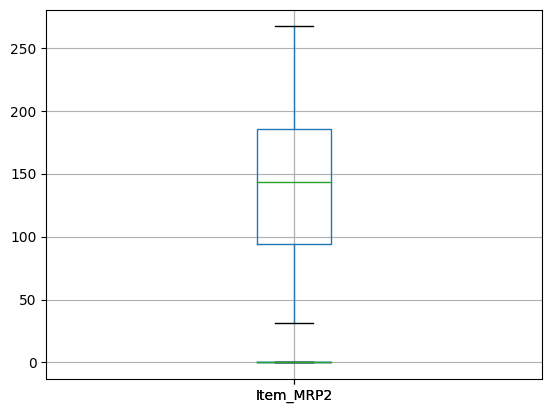

In [66]:
Item_Visibility_new.boxplot(column="Item_Visibility2")
Item_MRP_new.boxplot(column="Item_MRP2")

In [67]:
frames= [updated_df, Item_Visibility_new, Item_MRP_new]
result= pd.concat([updated_df, Item_MRP_new, Item_Visibility_new], axis=1, join ='inner')
result.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_MRP2,Item_Visibility2
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,249.8092,0.016047
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,48.2692,0.019278
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,141.6180,0.016760
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,182.0950,0.000000
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,53.8614,0.000000


In [68]:
dummy_df= pd.get_dummies(result, columns=['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'  ], drop_first= True)
dummy_df.head()


,Item_Identifier,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Item_Outlet_Sales,Item_MRP2,Item_Visibility2,Item_Fat_Content_Regular,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,FDA15,9.30,0.016047,Dairy,249.8092,OUT049,1999,3735.1380,249.8092,0.016047,False,True,False,False,False,True,False,False
1,DRC01,5.92,0.019278,Soft Drinks,48.2692,OUT018,2009,443.4228,48.2692,0.019278,True,True,False,False,True,False,True,False
2,FDN15,17.50,0.016760,Meat,141.6180,OUT049,1999,2097.2700,141.6180,0.016760,False,True,False,False,False,True,False,False
3,FDX07,19.20,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,732.3800,182.0950,0.000000,True,False,False,False,True,False,False,False
4,NCD19,8.93,0.000000,Household,53.8614,OUT013,1987,994.7052,53.8614,0.000000,False,False,False,False,True,True,False,False


In [71]:
# converting type of columns to 'category'
dummy_df['Item_Type'] = dummy_df['Item_Type'].astype('category')
dummy_df['Outlet_Identifier'] = dummy_df['Outlet_Identifier'].astype('category')
dummy_df['Outlet_Establishment_Year'] = dummy_df['Outlet_Establishment_Year'].astype('category')
# Assigning numerical values and storing in another column
dummy_df['Item_Type_cat'] =dummy_df['Item_Type'].cat.codes
dummy_df['Outlet_Identifier_cat'] =dummy_df['Outlet_Identifier'].cat.codes
dummy_df['Outlet_Establishment_Year_cat'] =dummy_df['Outlet_Establishment_Year'].cat.codes
dummy_df.head()


,Item_Identifier,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Item_Outlet_Sales,Item_MRP2,Item_Visibility2,...,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Type_cat,Outlet_Identifier_cat,Outlet_Establishment_Year_cat
0,FDA15,9.30,0.016047,Dairy,249.8092,OUT049,1999,3735.1380,249.8092,0.016047,...,True,False,False,False,True,False,False,4,9,4
1,DRC01,5.92,0.019278,Soft Drinks,48.2692,OUT018,2009,443.4228,48.2692,0.019278,...,True,False,False,True,False,True,False,14,3,8
2,FDN15,17.50,0.016760,Meat,141.6180,OUT049,1999,2097.2700,141.6180,0.016760,...,True,False,False,False,True,False,False,10,9,4
3,FDX07,19.20,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,732.3800,182.0950,0.000000,...,False,False,False,True,False,False,False,6,0,3
4,NCD19,8.93,0.000000,Household,53.8614,OUT013,1987,994.7052,53.8614,0.000000,...,False,False,False,True,True,False,False,9,1,1


In [72]:
list(dummy_df.columns)

['Item_Identifier',
 'Item_Weight',
 'Item_Visibility',
 'Item_Type',
 'Item_MRP',
 'Outlet_Identifier',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales',
 'Item_MRP2',
 'Item_Visibility2',
 'Item_Fat_Content_Regular',
 'Outlet_Size_Medium',
 'Outlet_Size_Small',
 'Outlet_Location_Type_Tier 2',
 'Outlet_Location_Type_Tier 3',
 'Outlet_Type_Supermarket Type1',
 'Outlet_Type_Supermarket Type2',
 'Outlet_Type_Supermarket Type3',
 'Item_Type_cat',
 'Outlet_Identifier_cat',
 'Outlet_Establishment_Year_cat']

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [75]:
y= dummy_df.Item_Outlet_Sales

#creating X
features= ['Item_Weight', 'Item_Visibility2','Item_MRP2', 'Item_Outlet_Sales', 'Item_Fat_Content_Regular', 'Outlet_Location_Type_Tier 2',  'Outlet_Location_Type_Tier 3',
'Outlet_Type_Supermarket Type1',
 'Outlet_Type_Supermarket Type2',
 'Outlet_Type_Supermarket Type3',
 'Item_Type_cat',
 'Outlet_Identifier_cat',
 'Outlet_Establishment_Year_cat']

X= dummy_df[features]
#split into validation and training
train_X, val_X, train_y, val_y = train_test_split(X,y, random_state=1)

In [76]:

#Random Forest Model
rf_model = RandomForestRegressor(random_state=1)

#fitting the model 
rf_model.fit(train_X, train_y)
predictions= rf_model.predict(val_X)

#calculation mae 
rf_val_mae =mean_absolute_error(predictions, val_y)

print("Validation MAE for Random Forest Model: {}".format(rf_val_mae))


Validation MAE for Random Forest Model: 1.0983950361332866


In [78]:
#Linear Regression Model
# creating a object

from sklearn.linear_model import LinearRegression


regressor = LinearRegression()

#training the model
regressor.fit(train_X, train_y)

#using the training dataset for the prediction
lrpredictions = regressor.predict(val_X)

lr_val_mae =mean_absolute_error(lrpredictions, val_y)

print("Validation MAE for Linear Regression Model: {}".format(lr_val_mae))



Validation MAE for Linear Regression Model: 1.7213839718053337e-12


In [79]:

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

xbgmodel = XGBClassifier()
xbgmodel.fit(train_X, train_y)

xbg_predictions = xbgmodel.predict(val_X)
xbg_val_mae =mean_absolute_error(xbg_predictions, val_y)

print("Validation MAE for Linear Regression Model: {}".format(xbg_val_mae))

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [   0    1    2 ... 3038 3039 3040], got [   33.9558    34.6216    35.2874 ... 11445.102  12117.56   13086.9648]